In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion() # Interactive mode

## Load data

In [2]:
# Data augmentation and normalization for training
# Data normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


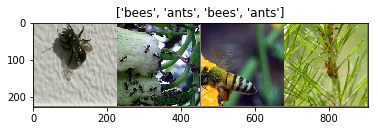

In [3]:
# Visualize a few images
def imshow(inp, title=None):
    ''' Imshow for Tensors'''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
        print()
        
    time_elapsed = time.time() - since
    print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

## Finetuning the ConvNet

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1866 Acc: 0.6270
val Loss: 0.0682 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.1253 Acc: 0.8115
val Loss: 0.0751 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.1647 Acc: 0.7623
val Loss: 0.1530 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.1446 Acc: 0.7377
val Loss: 0.0729 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.1492 Acc: 0.7664
val Loss: 0.0693 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.1637 Acc: 0.8033
val Loss: 0.0666 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.1550 Acc: 0.8279
val Loss: 0.1276 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.1129 Acc: 0.8443
val Loss: 0.0819 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.0827 Acc: 0.8566
val Loss: 0.0601 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.1037 Acc: 0.8238
val Loss: 0.0776 Acc: 0.8627

Epoch 10/24
----------
train Loss: 0.0654 Acc: 0.8893
val Loss: 0.0539 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0858 Acc: 0.8238
val Loss: 0.0660 Acc: 0.8954

Ep

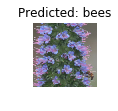

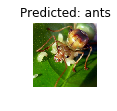

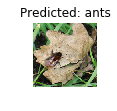

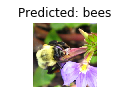

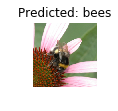

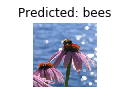

In [8]:
visualize_model(model_ft)

## ConvNet as a fixed feature extractor

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1473 Acc: 0.6230
val Loss: 0.0638 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.1649 Acc: 0.6885
val Loss: 0.0779 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.1306 Acc: 0.7623
val Loss: 0.0475 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.1131 Acc: 0.8115
val Loss: 0.0436 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.0921 Acc: 0.8607
val Loss: 0.0643 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.0802 Acc: 0.8730
val Loss: 0.0408 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.1302 Acc: 0.7705
val Loss: 0.0899 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.0848 Acc: 0.8648
val Loss: 0.0496 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0912 Acc: 0.8074
val Loss: 0.0393 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0728 Acc: 0.8975
val Loss: 0.0486 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0808 Acc: 0.8689
val Loss: 0.0442 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0784 Acc: 0.8770
val Loss: 0.0493 Acc: 0.9346

Ep

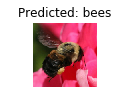

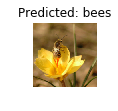

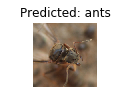

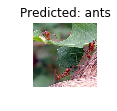

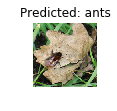

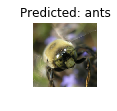

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [12]:
use_gpu

True